### walkthrough of METRIC

In [1]:
import rasterio as rio
import xarray as xar
from affine import Affine
import numpy as np
import pyproj
import sys
import daymetpy
import pandas as pd
#for METRIC
from collections import deque
import time

import numpy as np

import pyTSEB.meteo_utils as met
import pyTSEB.resistances as res
import pyTSEB.MO_similarity as MO
import pyTSEB.TSEB as tseb

with rio.open("test_metric/LT05_CU_012006_20020825_20190517_C01_V01_ST/LT05_CU_012006_20020825_20190517_C01_V01_ST.tif") as src:
    meta = src.meta
def get_lat_lon_center(da):
    """
    Gets the center of the raster in lon, lat coordinates by reprojecting to WGS84.
    """
    center = rio.transform.xy(Affine(*da.attrs['transform']), rows=da.sizes['y']//2, cols=da.sizes['x']//2, offset='center')
    outProj =pyproj.Proj(init='epsg:4326')
    lon,lat = pyproj.transform(da.attrs['crs'],outProj,center[0], center[1])
    return lon, lat
def get_lat_lon_arrs(da):
    """
    Gets the lon, lat coordinates by reprojecting to WGS84, in list of tuple form.
    """
    xs, ys = rio.transform.xy(Affine(*da.attrs['transform']), rows=np.arange(da.sizes['y']), cols=np.arange(da.sizes['x']), offset='center')
    lon_lat_arrs = []  
    outProj =pyproj.Proj(init='epsg:4326')
    lons, lats = pyproj.transform(da.attrs['crs'],outProj,xs, ys)
    return list(zip(lons, lats))

In [2]:
# test vars
Tr_K = xar.open_rasterio("test_metric/LT05_CU_012006_20020825_20190517_C01_V01_ST/LT05_CU_012006_20020825_20190517_C01_V01_ST.tif")
L_dn = xar.open_rasterio("test_metric/LT05_CU_012006_20020825_20190517_C01_V01_ST/LT05_CU_012006_20020825_20190517_C01_V01_DRAD.tif")
emis = xar.open_rasterio("test_metric/LT05_CU_012006_20020825_20190517_C01_V01_ST/LT05_CU_012006_20020825_20190517_C01_V01_EMIS.tif")

center = get_lat_lon_center(Tr_K)

In [3]:
coords = get_lat_lon_arrs(Tr_K)
coord_arr = np.array(coords, dtype=np.dtype("float,float"))

In [4]:

# need to test if numpy masked arrays or xarray masking works better
#np.ma.masked_where(L_dn==-9999, L_dn)

emis = emis.where(L_dn!=-9999)
emis = emis * .0001

L_dn = L_dn.where(L_dn!=-9999)
L_dn = L_dn * .001

Tr_K = Tr_K.where(Tr_K!=-9999)
Tr_K = Tr_K * .1

In [5]:
aoi_met = daymetpy.daymet_timeseries(lon=center[0], lat=center[1], start_year=2002, end_year=2002)

In [6]:
aoi_met

,year,yday,dayl,prcp,srad,swe,tmax,tmin,vp
2002-01-01,2002.0,1.0,31795.199219,0.0,182.399994,0.0,-5.5,-18.5,160.0
2002-01-02,2002.0,2.0,31795.199219,0.0,224.000000,0.0,-0.5,-21.0,120.0
2002-01-03,2002.0,3.0,31795.199219,0.0,214.399994,0.0,6.0,-12.0,200.0
2002-01-04,2002.0,4.0,31795.199219,0.0,150.399994,0.0,5.0,-5.0,400.0
2002-01-05,2002.0,5.0,31795.199219,0.0,182.399994,0.0,3.0,-10.0,240.0
...,...,...,...,...,...,...,...,...,...
2002-12-27,2002.0,361.0,31449.599609,0.0,198.399994,0.0,6.5,-9.0,280.0
2002-12-28,2002.0,362.0,31449.599609,0.0,156.800003,0.0,12.0,1.0,600.0
2002-12-29,2002.0,363.0,31449.599609,0.0,166.399994,0.0,12.0,0.0,560.0
2002-12-30,2002.0,364.0,31449.599609,0.0,185.600006,0.0,6.5,-7.0,360.0


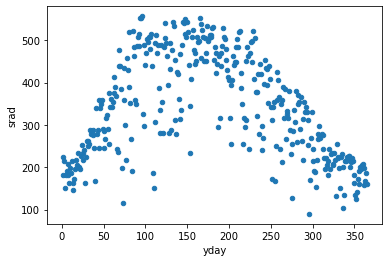

In [7]:
%matplotlib inline
aoi_met.plot.scatter(x="yday", y="srad")

generating roughness and zero plane displacement arrays

In [8]:
aoi_met.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2002-12-22', '2002-12-23', '2002-12-24', '2002-12-25',
               '2002-12-26', '2002-12-27', '2002-12-28', '2002-12-29',
               '2002-12-30', '2002-12-31'],
              dtype='datetime64[ns]', length=365, freq=None)

In [12]:
import pvlib
import datetime
from timezonefinder import TimezoneFinder

time = pd.to_datetime(datetime.datetime(2002, 8, 3, 10, 4))
time = pd.DatetimeIndex([time])
tf = TimezoneFinder(in_memory=True)
timezone = tf.certain_timezone_at(lng=center[0], lat=center[1]) 
time = time.tz_localize(timezone)
solar_df = pvlib.solarposition.get_solarposition(time,center[1], center[0]) # can be made more accurate with temp and pressure from daymet

Need to calc roughness for every single pixel, follow chain of funcs, need to use shoprtwave bands to get LAI approximation (check other pymetric if need be) and NDVI

In [ ]:
in_data['SZA'], in_data['SAA'] = met.calc_sun_angles(
    lat, lon, stdlon, doy, in_data['time'])

In [ ]:
difvis, difnir, fvis, fnir = rad.calc_difuse_ratio(
    in_data['S_dn'], in_data['SZA'], press=in_data['p'])
out_data['fvis'] = fvis
out_data['fnir'] = fnir
out_data['Skyl'] = difvis * fvis + difnir * fnir
out_data['S_dn_dir'] = in_data['S_dn'] * (1.0 - out_data['Skyl'])
out_data['S_dn_dif'] = in_data['S_dn'] * out_data['Skyl']

del difvis, difnir, fvis, fnir

# ======================================
# NEt radiation for bare soil
noVegPixels = np.logical_and(in_data['LAI'] == 0, mask == 1)
# Calculate roughness
out_data['z_0M'][noVegPixels] = in_data['z0_soil'][noVegPixels]
out_data['d_0'][noVegPixels] = 0

# Net shortwave radition for bare soil
spectraGrdOSEB = out_data['fvis'] * \
    in_data['rho_vis_S'] + out_data['fnir'] * in_data['rho_nir_S']
out_data['R_ns1'][noVegPixels] = (1. - spectraGrdOSEB[noVegPixels]) * \
    (out_data['S_dn_dir'][noVegPixels] + out_data['S_dn_dif'][noVegPixels])


# ======================================
# Then process vegetated cases
# Calculate roughness
i = np.logical_and(in_data['LAI'] > 0, mask == 1)

out_data['z_0M'][i], out_data['d_0'][i] = \
    res.calc_roughness(in_data['LAI'][i],
                       in_data['h_C'][i],
                       w_C=in_data['w_C'][i],
                       landcover=in_data['landcover'][i],
                       f_c=in_data['f_c'][i])

In [ ]:
# mocks
T_A_K = 25.0+273.15
u = 2 #m/s
ea = 20 # mb, mock value under the saturation vapor pressure at 25 Celsius
p = 1013 # mb
Sn = 500 # flux density, guestimate based on center of image and rough day of year daymet data
L_dn = L_dn
emis = emis
z_0M = 
d_0 =
z_u,
z_T,
cold_pixel,
hot_pixel,
LE_cold,
LE_hot=0,
use_METRIC_resistance=True,
calcG_params=[[1], 0.35],
UseL=False,
UseDEM=False


Scale factors for temperature product variables documented in: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1330-LandsatSurfaceTemperature_ProductGuide-v2.pdf

In [ ]:
from collections import deque
import time

import numpy as np

import pyTSEB.meteo_utils as met
import pyTSEB.resistances as res
import pyTSEB.MO_similarity as MO
import pyTSEB.TSEB as tseb

# ==============================================================================
# List of constants used in TSEB model and sub-routines
# ==============================================================================
# Threshold for relative change in Monin-Obukhov lengh to stop the iterations
L_thres = 0.001
# mimimun allowed friction velocity
u_friction_min = 0.01
# Maximum number of interations
ITERATIONS = 15
# kB coefficient
kB = 0
# Stephan Boltzmann constant (W m-2 K-4)
SB = 5.670373e-8
# von Karman constant
KARMAN = 0.41

TALL_REFERENCE = 1
SHORT_REFERENCE = 0


def METRIC(Tr_K,
           T_A_K,
           u,
           ea,
           p,
           Sn,
           L_dn,
           emis,
           z_0M,
           d_0,
           z_u,
           z_T,
           cold_pixel,
           hot_pixel,
           LE_cold,
           LE_hot=0,
           use_METRIC_resistance=True,
           calcG_params=[[1], 0.35],
           UseL=False,
           UseDEM=False):

    '''Calulates bulk fluxes using METRIC model
    Parameters
    ----------
    Tr_K : float (2D ndarray)
        Radiometric composite temperature (Kelvin).
    T_A_K : float
        Air temperature (Kelvin).
    u : float
        Wind speed above the canopy (m s-1).
    ea : float
        Water vapour pressure above the canopy (mb).
    p : float
        Atmospheric pressure (mb), use 1013 mb by default.
    S_n : float
        Solar irradiance (W m-2).
    L_dn : float
        Downwelling longwave radiation (W m-2)
    emis : float
        Surface emissivity.
    z_0M : float
        Aerodynamic surface roughness length for momentum transfer (m).
    d_0 : float
        Zero-plane displacement height (m).
    z_u : float
        Height of measurement of windspeed (m).
    z_T : float
        Height of measurement of air temperature (m).
    cold_pixel : tuple
        pixel coordinates (row, col) for the cold endmember
    hot_pixel : tuple
        pixel coordinates (row, col) for the hot endmember
    calcG_params : list[list,float or array], optional
        Method to calculate soil heat flux,parameters.
            * [[1],G_ratio]: default, estimate G as a ratio of Rn_S, default Gratio=0.35.
            * [[0],G_constant] : Use a constant G, usually use 0 to ignore the computation of G.
            * [[2,Amplitude,phase_shift,shape],time] : estimate G from Santanello and Friedl with G_param list of parameters (see :func:`~TSEB.calc_G_time_diff`).
    UseL : Optional[float]
        If included, its value will be used to force the Moning-Obukhov stability length.
    Returns
    -------
    flag : int
        Quality flag, see Appendix for description.
    Ln : float
        Net longwave radiation (W m-2)
    LE : float
        Latent heat flux (W m-2).
    H : float
        Sensible heat flux (W m-2).
    G : float
        Soil heat flux (W m-2).
    R_A : float
        Aerodynamic resistance to heat transport (s m-1).
    u_friction : float
        Friction velocity (m s-1).
    L : float
        Monin-Obuhkov length (m).
    n_iterations : int
        number of iterations until convergence of L.
    References
    ----------
    '''

    # Convert input scalars to numpy arrays and check parameters size
    Tr_K = np.asarray(Tr_K)
    (T_A_K,
     u,
     ea,
     p,
     Sn,
     L_dn,
     emis,
     z_0M,
     d_0,
     z_u,
     z_T,
     LE_cold,
     LE_hot,
     calcG_array) = map(tseb._check_default_parameter_size,
                        [T_A_K,
                         u,
                         ea,
                         p,
                         Sn,
                         L_dn,
                         emis,
                         z_0M,
                         d_0,
                         z_u,
                         z_T,
                         LE_cold,
                         LE_hot,
                         calcG_params[1]],
                        [Tr_K] * 14)

    # Create the output variables
    [Ln, LE, H, G, R_A, iterations] = [np.zeros(Tr_K.shape)+np.NaN for i in range(6)]
    flag = np.zeros(Tr_K.shape, dtype=np.byte)
    # iteration of the Monin-Obukhov length
    if isinstance(UseL, bool):
        # Initially assume stable atmospheric conditions and set variables for
        L = np.zeros(Tr_K.shape) + np.inf
        max_iterations = ITERATIONS
    else:  # We force Monin-Obukhov lenght to the provided array/value
        L = np.ones(Tr_K.shape) * UseL
        max_iterations = 1  # No iteration

    if isinstance(UseDEM, bool):
        Tr_datum = np.asarray(Tr_K)
        Ta_datum = np.asarray(T_A_K)
    else:
        gamma_w = met.calc_lapse_rate_moist(T_A_K, ea, p)
        Tr_datum = Tr_K + gamma_w * UseDEM
        Ta_datum = T_A_K + gamma_w * UseDEM

    # Calculate the general parameters
    rho = met.calc_rho(p, ea, T_A_K)  # Air density
    c_p = met.calc_c_p(p, ea)  # Heat capacity of air
    rho_datum = met.calc_rho(p, ea, Ta_datum)  # Air density

    # Calc initial Monin Obukhov variables
    u_friction = MO.calc_u_star(u, z_u, L, d_0, z_0M)
    u_friction = np.maximum(u_friction_min, u_friction)

    z_0H = res.calc_z_0H(z_0M, kB=kB)

    # Calculate Net radiation
    Ln = emis * L_dn - emis * met.calc_stephan_boltzmann(Tr_K)
    Rn = np.asarray(Sn + Ln)

    # Compute Soil Heat Flux
    i = np.ones(Rn.shape, dtype=bool)
    G[i] = tseb.calc_G([calcG_params[0], calcG_array], Rn, i)

    # Get cold and hot variables
    Rn_endmembers = np.array([Rn[cold_pixel], Rn[hot_pixel]])
    G_endmembers = np.array([G[cold_pixel], G[hot_pixel]])
    LE_endmembers = np.array([LE_cold[cold_pixel], LE_hot[hot_pixel]])
    u_friction_endmembers = np.array([u_friction[cold_pixel], u_friction[hot_pixel]])
    u_endmembers = np.array([u[cold_pixel], u[hot_pixel]])
    z_u_endmembers = np.array([z_u[cold_pixel], z_u[hot_pixel]])
    Ta_datum_endmembers = np.array([Ta_datum[cold_pixel], Ta_datum[hot_pixel]])
    z_T_endmembers = np.array([z_T[cold_pixel], z_T[hot_pixel]])
    rho_datum_endmembers = np.array([rho_datum[cold_pixel], rho_datum[hot_pixel]])
    c_p_endmembers = np.array([c_p[cold_pixel], c_p[hot_pixel]])
    d_0_endmembers = np.array([d_0[cold_pixel], d_0[hot_pixel]])
    z_0M_endmembers = np.array([z_0M[cold_pixel], z_0M[hot_pixel]])
    z_0H_endmembers = np.array([z_0H[cold_pixel], z_0H[hot_pixel]])

    H_endmembers = calc_H_residual(Rn_endmembers, G_endmembers, LE=LE_endmembers)

    # ==============================================================================
    #     HOT and COLD PIXEL ITERATIONS FOR MONIN-OBUKHOV LENGTH TO CONVERGE
    # ==============================================================================
    # Initially assume stable atmospheric conditions and set variables for
    L_old = np.ones(2)
    L_diff = np.ones(2) * float('inf')
    for iteration in range(max_iterations):
        if np.all(L_diff < L_thres):
            break

        if isinstance(UseL, bool):
            # Recaulculate L and the difference between iterations
            L_endmembers = MO.calc_L(u_friction_endmembers,
                                     Ta_datum_endmembers,
                                     rho_datum_endmembers,
                                     c_p_endmembers,
                                     H_endmembers,
                                     LE_endmembers)

            L_diff = np.fabs(L_endmembers - L_old) / np.fabs(L_old)
            L_old = np.array(L_endmembers)
            L_old[np.fabs(L_old) == 0] = 1e-36

            u_friction_endmembers = MO.calc_u_star(u_endmembers,
                                                   z_u_endmembers,
                                                   L_endmembers,
                                                   d_0_endmembers,
                                                   z_0M_endmembers)

            u_friction_endmembers = np.maximum(u_friction_min, u_friction_endmembers)

    # Hot and Cold aerodynamic resistances
    if use_METRIC_resistance is True:
        R_A_params = {"z_T": np.array([2.0, 2.0]),
                      "u_friction": u_friction_endmembers,
                      "L": L_endmembers,
                      "d_0": np.array([0.0, 0.0]),
                      "z_0H": np.array([0.1, 0.1])}
    else:
        R_A_params = {"z_T": z_T_endmembers,
                      "u_friction": u_friction_endmembers,
                      "L": L_endmembers,
                      "d_0": d_0_endmembers,
                      "z_0H": z_0H_endmembers}

    R_A_endmembers, _, _ = tseb.calc_resistances(tseb.KUSTAS_NORMAN_1999, {"R_A": R_A_params})

    # Calculate the temperature gradients
    dT_endmembers = calc_dT(H_endmembers,
                            R_A_endmembers,
                            rho_datum_endmembers,
                            c_p_endmembers)

    # dT constants
    # Note: the equations for a and b in the Allen 2007 paper (eq 50 and 51) appear to be wrong.
    dT_b = (dT_endmembers[1] - dT_endmembers[0]) / (Tr_datum[hot_pixel] - Tr_datum[cold_pixel])
    dT_a = dT_endmembers[1] - dT_b * Tr_datum[hot_pixel]

    # Apply the constant to the whole image
    dT = dT_a + dT_b * Tr_datum                         # Allen 2007 eq. 29

# ==============================================================================
#     ITERATIONS FOR MONIN-OBUKHOV LENGTH AND H TO CONVERGE
# ==============================================================================
    # Initially assume stable atmospheric conditions and set variables for
    L_queue = deque([np.ones(dT.shape)], 6)
    L_converged = np.asarray(np.zeros(Tr_K.shape)).astype(bool)
    L_diff_max = np.inf
    i = np.ones(dT.shape, dtype=bool)
    start_time = time.time()
    loop_time = time.time()

    for n_iterations in range(max_iterations):

        iterations[i] = n_iterations
        if np.all(L_converged):
            break
        current_time = time.time()
        loop_duration = current_time - loop_time
        loop_time = current_time
        total_duration = loop_time - start_time
        print("Iteration: %d, non-converged pixels: %d, max L diff: %f, total time: %f, loop time: %f" %
              (n_iterations, np.sum(~L_converged[i]), L_diff_max, total_duration, loop_duration))

        i = ~L_converged

        if use_METRIC_resistance is True:
            R_A_params = {"z_T": np.array([2.0, 2.0]),
                          "u_friction": u_friction[i],
                          "L": L[i],
                          "d_0": np.array([0.0, 0.0]),
                          "z_0H": np.array([0.1, 0.1])}
        else:
            R_A_params = {"z_T": z_T[i],
                          "u_friction": u_friction[i],
                          "L": L[i],
                          "d_0": d_0[i],
                          "z_0H": z_0H[i]}

            R_A[i], _, _ = tseb.calc_resistances(tseb.KUSTAS_NORMAN_1999, {"R_A": R_A_params})

        H[i] = calc_H(dT[i], rho[i], c_p[i], R_A[i])
        LE[i] = Rn[i] - G[i] - H[i]

        if isinstance(UseL, bool):
            # Now L can be recalculated and the difference between iterations
            # derived
            L[i] = MO.calc_L(u_friction[i], T_A_K[i], rho[i], c_p[i], H[i], LE[i])

            u_friction[i] = MO.calc_u_star(u[i], z_u[i], L[i], d_0[i], z_0M[i])
            u_friction[i] = np.asarray(np.maximum(u_friction_min, u_friction[i]))
            
            # We check convergence against the value of L from previous iteration but as well
            # against values from 2 or 3 iterations back. This is to catch situations (not
            # infrequent) where L oscillates between 2 or 3 steady state values.
            L_new = np.array(L)
            L_new[L_new == 0] = 1e-36
            L_queue.appendleft(L_new)
            i = ~L_converged
            L_converged[i] = _L_diff(L_queue[0][i], L_queue[1][i]) < L_thres
            L_diff_max = np.max(_L_diff(L_queue[0][i], L_queue[1][i]))
            if len(L_queue) >= 4:
                i = ~L_converged
                L_converged[i] = np.logical_and(_L_diff(L_queue[0][i], L_queue[2][i]) < L_thres,
                                                _L_diff(L_queue[1][i], L_queue[3][i]) < L_thres)
            if len(L_queue) == 6:
                i = ~L_converged
                L_converged[i] = np.logical_and.reduce((_L_diff(L_queue[0][i], L_queue[3][i]) < L_thres,
                                                        _L_diff(L_queue[1][i], L_queue[4][i]) < L_thres,
                                                        _L_diff(L_queue[2][i], L_queue[5][i]) < L_thres))

    flag, Ln, LE, H, G, R_A, u_friction, L, iterations = map(
        np.asarray, (flag, Ln, LE, H, G, R_A, u_friction, L, iterations))

    return flag, Ln, LE, H, G, R_A, u_friction, L, iterations


def _L_diff(L, L_old):
    L_diff = np.asarray(np.fabs(L - L_old) / np.fabs(L_old))
    L_diff[np.isnan(L_diff)] = float('inf')
    return L_diff


def calc_dT(H, R_AH, rho, c_p):
    # Allen 2007 eq. 46 and 49
    dT = H * R_AH / (rho * c_p)
    return dT


def calc_G_Allen(Rn, LST, albedo, NDVI):
    '''Calculate soil heat flux
    Parameters
    ----------
    Rn : net radiation (W m-2)
    LST : Land Surface Temperature (Kelvin)
    albedo : surface broadband albedo
    NDVI : Normalized Difference Vegetation Index
    Returns
    -------
    G_flux : Soil heat flux (W m-2)
    Based on Allen 2007 eq. 26'''

    G_flux = Rn * (LST - 273.15) * (0.0038 + 0.0074*albedo) * (1 - 0.98*(NDVI**4))

    return G_flux


def calc_H(dT, rho, cp, R_AH):
    ''' Calculates the Sensible heat flux using the bulk transfer equation
    Parameters
    ----------
    dT : float or array
        gradient temperature
    rho : float or array
        Density of air
    cp : float or array
        heat capacity of air
    R_AH : float or array
        aerodynamic resistance to heat transport (s m-1)
    Returns
    -------
    H : float or array
        Sensible heat flux (W m-2)
    References
    ----------
    based on Allen 2007 eq 28'''

    H = rho * cp * dT / R_AH

    return H


def calc_H_residual(Rn, G, LE=0.0):
    ''' Calculates the Sensible heat flux as residual of the energy balance
    Parameters
    ----------
    Rn : float or array
        net radiation (W m-2)
    G : float or array
        Soil heat flux (W m-2)
    LE : float or array
        latent heat flux (W m-2) default=0, for dry pixels
    Returns
    -------
    H : float or array
        Sensible heat flux (W m-2)
    '''
    H = Rn - G - LE
    return H


def pet_asce(T_A_K, u, ea, p, Sdn, z_u, z_T, f_cd=1, reference=TALL_REFERENCE):
    '''Calcultaes the latent heat flux for well irrigated and cold pixel using
    ASCE potential ET from a tall (alfalfa) crop
    Parameters
    ----------
    T_A_K : float or array
        Air temperature (Kelvin).
    u : float or array
        Wind speed above the canopy (m s-1).
    ea : float or array
        Water vapour pressure above the canopy (mb).
    p : float or array
        Atmospheric pressure (mb), use 1013 mb by default.
    Sdn : float or array
        Solar irradiance (W m-2).
    z_u : float or array
        Height of measurement of windspeed (m).
    z_T : float or array
        Height of measurement of air temperature (m).
    f_cd : float or array
        cloudiness factor, default = 1
    reference : bool
        If true, reference ET is for a tall canopy (i.e. alfalfa)
    Returns
    -------
    LE : float or array
        Potential latent heat flux (W m-2)
    '''
    # Atmospheric constants
    delta = 10. * met.calc_delta_vapor_pressure(T_A_K)  # slope of saturation water vapour pressure in mb K-1
    lambda_ = met.calc_lambda(T_A_K)                     # latent heat of vaporization MJ kg-1
    c_p = met.calc_c_p(p, ea)  # Heat capacity of air
    psicr = met.calc_psicr(c_p, p, lambda_)                     # Psicrometric constant (mb K-1)
    es = met.calc_vapor_pressure(T_A_K)             # saturation water vapour pressure in mb

    # Net shortwave radiation
    # Sdn = Sdn * 3600 / 1e6 # W m-2 to MJ m-2 h-1
    albedo = 0.23
    Sn = Sdn * (1.0 - albedo)
    # Net longwave radiation
    Ln = calc_Ln(T_A_K, ea, f_cd=f_cd)
    # Net radiation
    Rn = Sn + Ln
    # Soil heat flux
    if reference == TALL_REFERENCE:
        G_ratio = 0.04
        h_c = 0.5
        C_d = 0.25
        C_n = 66.0
        # R_s = 30.0
    else:
        G_ratio = 0.1
        h_c = 0.12
        C_d = 0.24
        C_n = 37.0
        # R_s = 50.0

    # Soil heat flux
    G = G_ratio * Rn
    # Windspeed at 2m height
    z_0M = h_c * 0.123
    d = h_c * 0.67
    u_2 = wind_profile(u, z_u, z_0M, d, 2.0)

    LE = (delta * (Rn - G) + psicr * C_n * u_2 * (es - ea) / T_A_K) / (delta + psicr * C_d * u_2)

    return LE


def pet_fao56(T_A_K, u, ea, p, Sdn, z_u, z_T, f_cd=1, reference=SHORT_REFERENCE):
    '''Calcultaes the latent heat flux for well irrigated and cold pixel using
    FAO56 potential ET from a short (grass) crop
    Parameters
    ----------
    T_A_K : float or array
        Air temperature (Kelvin).
    u : float or array
        Wind speed above the canopy (m s-1).
    ea : float or array
        Water vapour pressure above the canopy (mb).
    p : float or array
        Atmospheric pressure (mb), use 1013 mb by default.
    Sdn : float or array
        Solar irradiance (W m-2).
    z_u : float or array
        Height of measurement of windspeed (m).
    z_T : float or array
        Height of measurement of air temperature (m).
    f_cd : float or array
        cloudiness factor, default = 1
    reference : bool
        If true, reference ET is for a tall canopy (i.e. alfalfa)
    '''
    # Atmospheric constants
    delta = 10. * met.calc_delta_vapor_pressure(T_A_K)  # slope of saturation water vapour pressure in mb K-1
    lambda_ = met.calc_lambda(T_A_K)                     # latent heat of vaporization MJ kg-1
    c_p = met.calc_c_p(p, ea)  # Heat capacity of air
    psicr = met.calc_psicr(c_p, p, lambda_)                     # Psicrometric constant (mb K-1)
    es = met.calc_vapor_pressure(T_A_K)             # saturation water vapour pressure in mb
    rho = met.calc_rho(p, ea, T_A_K)

    # Net shortwave radiation
    # Sdn = Sdn * 3600 / 1e6 # W m-2 to MJ m-2 h-1
    albedo = 0.23
    Sn = Sdn * (1.0 - albedo)
    # Net longwave radiation
    Ln = calc_Ln(T_A_K, ea, f_cd=f_cd)
    # Net radiation
    Rn = Sn + Ln

    if reference == TALL_REFERENCE:
        G_ratio = 0.04
        h_c = 0.5
    else:
        G_ratio = 0.1
        h_c = 0.12

    R_c = 70.0

    # Soil heat flux
    G = G_ratio * Rn
    # Windspeed at 2m height
    z_0M = h_c * 0.123
    d = h_c * 2./3.
    u_2 = wind_profile(u, z_u, z_0M, d, 2.0)
    R_a = 208./u_2

    LE = (delta * (Rn - G) + rho * c_p * (es - ea) / R_a) / (delta + psicr * (1.0 + R_c / R_a))

    return LE


def calc_Ln(T_A_K, ea, f_cd=1):
    ''' Estimates net longwave radiation for potential ET
    Parameters
    ----------
    T_A_K : float or array
        Air temperature (Kelvin).
    u : float or array
        Wind speed above the canopy (m s-1).
    ea : float or array
        Water vapour pressure above the canopy (mb).
    f_cd : float or array
        cloudiness factor
    Returns
    -------
    Ln : float or array
        Net longwave radiation (W m-2)
    '''

    Ln = SB * f_cd * (0.34 - 0.14 * np.sqrt(ea*0.1)) * T_A_K**4

    return Ln


def calc_cloudiness(Sdn, S_0):

    f_cd = 1.35 * Sdn/S_0 - 0.35
    f_cd = np.clip(f_cd, 0.05, 1.0)
    return f_cd


def wind_profile(u, z_u, z_0M, d, z):

    u_z = u * np.log((z - d)/z_0M) / np.log((z_u - d)/z_0M)

    return u_z

#### this has code specific to the SENET project, the pyMETRIC.py file. METRIC function in METRIC.py contains the model and we should focus on using that probably, but with pyMETRIC as a guide for implementing on rasters

In [6]:
from collections import OrderedDict
from os.path import splitext, dirname, exists
from os import mkdir

import numpy as np
import ast
import gdal
from netCDF4 import Dataset

# S_* are flags to determine if output should be saved. N stands for No, P for Priamry, A for Ancillary
from pyTSEB.PyTSEB import S_N, S_P, S_A 

# this comes with all the land cover IDs for the IGBP global land cover classication. IDs will need to change for NLCD.
# also comes with func to calculate the roughness and zero plane displacement. This could be substituted for uniform veg calcualtion if we only care about crops.
from pyTSEB import resistances as res 

# calculates sun zenith angles based on time and lcoation, pressure based on altitude, downwelling longwave from air T
# and lapse rate to correct T reference and air temperature based on vapor pressure and air pressure
# not sure what the lapse rate temperature normalization is for..
from pyTSEB import meteo_utils as met


# function for bruetsart's equation for atmospheric emissivity to calc downwelling longwave,
# Esimate diffuse and direct irradiance (shortwave incoming to surface). inputs to this parsing func are 
# S_dn, incoming shortwave, solar zenith, solar constant and Sn_c canopy net shortwave radiation and Sn_S soil net shortwave radiation
from pyTSEB import net_radiation as rad
from pyMETRIC import METRIC, endmember_search
import xarray

### Questions

Wha is an adiabatic lapse rate? Why is it used to normalize temperature like so?

```python
    gamma_w = met.calc_lapse_rate_moist(in_data['T_A1'],
                                        in_data['ea'],
                                        in_data['p'])
    Tr_datum = in_data['T_R1'] + gamma_w * in_data['alt']
    Ta_datum = in_data['T_A1'] + gamma_w * in_data['alt']
```

# code graveyard

In [ ]:
def get_x_y_arrs(da):
    """
    Takes array read with open_rasterio, outputs x and y arrays of same shape.
    """
    transform = Affine.from_gdal(*da.attrs['transform'])
    nx, ny = da.sizes['x'], da.sizes['y']
    x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
    return x, y

### Setup

1. Setup conda env
2. install setuptools
3. install https://github.com/hectornieto/pyPro4Sail a dependency
4. install https://github.com/hectornieto/pyMETRIC the ET model
5. install https://github.com/khufkens/daymetpy for ancillary inputs

Example reference using Daymet for ancillary inputs to estimate ET with Landsat:https://www.sciencedirect.com/science/article/pii/S0034425715302650

projection info for daymet: https://wiki.cyverse.org/wiki/display/~tyson_swetnam/Raster+Calculations

To get daymet data for a 512x512 scene and build an array it will take 235 api calls which may not be too bad.

This func will get the lat, lon tuples of a raster to be used to get daymet data: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html

I've chosen daymet over mesonet because it is easier to acquire, but later spatially interpolated Mesonet and other data sources can be used for better accuracy. [This paper](https://www.sciencedirect.com/science/article/pii/S1161030116302076#bib0005) notes:"While, on average, simulated yields using Daymet were in closer agreement with simulations based on MWD compared with PRISM (RMSE%: 18 vs. 24%), there were still large differences in simulated yield in 20% of the site-years. And, perhaps more importantly, these differences were not predictable as they were not associated with any spatial pattern in weather, topography, or weather network. While GWD might be useful for applications that only require temperature, such as crop stage prediction or quantification of early frost risk, water deficit and simulated yields for specific site-years are highly uncertain and there is no way to ex-ante predict the magnitude and direction of the bias, which undermines utility of GWD for field-specific or real-time agronomic applications."

Daymet overview: https://daymet.ornl.gov/overview

Daymet has been critiqued in this 2017 paper for not homogenizing the grid to account for climate change over time in places that are far from station data. It has also been critiqued for artifacts where there is no station data (Walton and Hall, An Assessment of High-Resolution Gridded Temperature Datasets
over California)

The variables we don't have and which are most difficult to get probably are related to wind speed and vegetation structure:
u, z_0M, d_0, z_u. Maybe we get these from mesonet stations, need to look at the literature to see what folks do about this.

In [9]:
import sys
import daymetpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

denver_loc = (-104.9903, 39.7392)
miami_loc = (-80.2089, 25.7753)

denver = daymetpy.daymet_timeseries(lon=denver_loc[0], lat=denver_loc[1], start_year=2012, end_year=2014)

In [10]:
denver

,year,yday,dayl,prcp,srad,swe,tmax,tmin,vp
2012-01-01,2012.0,1.0,33177.601562,0.0,256.000000,4.0,8.5,-7.0,320.0
2012-01-02,2012.0,2.0,33177.601562,0.0,230.399994,4.0,5.0,-8.0,320.0
2012-01-03,2012.0,3.0,33523.199219,0.0,278.399994,4.0,13.0,-5.0,320.0
2012-01-04,2012.0,4.0,33523.199219,0.0,291.200012,4.0,15.0,-5.0,320.0
2012-01-05,2012.0,5.0,33523.199219,0.0,284.799988,4.0,17.0,-2.0,360.0
...,...,...,...,...,...,...,...,...,...
2014-12-27,2014.0,361.0,33177.601562,0.0,227.199997,8.0,-3.0,-15.5,200.0
2014-12-28,2014.0,362.0,33177.601562,0.0,259.200012,8.0,0.5,-15.0,200.0
2014-12-29,2014.0,363.0,33177.601562,0.0,259.200012,8.0,1.5,-14.0,200.0
2014-12-30,2014.0,364.0,33177.601562,3.0,147.199997,8.0,-10.0,-20.0,120.0


In [14]:
import pyMETRIC.METRIC as met

 Parameters
        ----------
        CHECK (landsat) Tr_K : float
            Radiometric composite temperature (Kelvin).
        CHECK (daymet convert to Kelvin, height is estimated at 2 meter) T_A_K : float
            Air temperature (Kelvin).
        (assume? mesonet stations?) u : float
            Wind speed above the canopy (m s-1).
        CHECK (daymet needs to be converted from pascals to mb) ea : float
            Water vapour pressure above the canopy (mb).
        CHECK (will use default or calc from elevation) p : float
            Atmospheric pressure (mb), use 1013 mb by default.
        CHECK (daymet, right units in W/m/-2 already, but also consider pyMETRIC suggested method from albedo...) S_n : float
            Solar irradiance (W m-2).
        (estimated from vapor pressure and air temp (to get atm emissivity)) L_dn : float
            Downwelling longwave radiation (W m-2)
        (https://modis.gsfc.nasa.gov/data/dataprod/mod11.php) emis : float
            Surface emissivity.
        CHECK (.02*uniform vegetation height=z_0m source: C&N) z_0M : float
            Aerodynamic surface roughness length for momentum transfer (m).
        CHECK (.6*uniform vegetation height=d_0 source: C&N) d_0 : float
            Zero-plane displacement height (m).
        z_u : float
            Height of measurement of windspeed (m).
        CHECK (see daymet docs, 2 meter:https://daymet.ornl.gov/overview.html) z_T : float
            Height of measurement of air temperature (m).
        cold_pixel : tuple
            pixel coordinates (row, col) for the cold endmember
        hot_pixel : tuple
            pixel coordinates (row, col) for the hot endmember
        calcG_params : list[list,float or array], optional
            Method to calculate soil heat flux,parameters.

Also these params are needed for exhaustive hot/cold pixel search, easily computed from Landsat and MODIS for albedo. Or possibly Landsat? this is what EEflux did to estiamte albedo

"Albedo – This represents total, integrated reflectance across the electromagnetic spectrum. It is calculated from the six primary short-wave bands and is useful for energy balance work. Based on Tasumi et al., 2008, ASCE J. Hydrologic Engineering."

    vi_array : numpy array
        Vegetation Index array (-)
    lst_array : numpy array
        Land Surface Temperature array (Kelvin)
    cv_ndvi : numpy array
        Coefficient of variation of Vegetation Index as homogeneity measurement
        from neighboring pixels
    std_lst : numpy array
        Standard deviation of LST as homogeneity measurement
        from neighboring pixels
    cv_albedo : numpy array
        Coefficient of variation of albdeo as homogeneity measurement
        from neighboring pixels

[Good overview of METRIC](https://onlinelibrary.wiley.com/doi/full/10.1111/jawr.12056)

In [ ]:
import pyMETRIC.METRIC as METRIC 
output=METRIC.METRIC(Tr_K, T_A_K, u, ea, p, Sn, L_dn, emis, z_0M, d_0, z_u, z_T, cold_pixel, hot_pixel, LE_cold)

In [15]:
help(met)

Help on module pyMETRIC.METRIC in pyMETRIC:

NAME
    pyMETRIC.METRIC - Created on Sat May 30 10:59:35 2015

DESCRIPTION
    @author: hector

FUNCTIONS
    METRIC(Tr_K, T_A_K, u, ea, p, Sn, L_dn, emis, z_0M, d_0, z_u, z_T, cold_pixel, hot_pixel, LE_cold, LE_hot=0, use_METRIC_resistance=True, calcG_params=[[1], 0.35], UseL=False, UseDEM=False)
        Calulates bulk fluxes using METRIC model
        
        Parameters
        ----------
        Tr_K : float
            Radiometric composite temperature (Kelvin).
        T_A_K : float
            Air temperature (Kelvin).
        u : float
            Wind speed above the canopy (m s-1).
        ea : float
            Water vapour pressure above the canopy (mb).
        p : float
            Atmospheric pressure (mb), use 1013 mb by default.
        S_n : float
            Solar irradiance (W m-2).
        L_dn : float
            Downwelling longwave radiation (W m-2)
        emis : float
            Surface emissivity.
        z_0M : 